# Graphical Models

| Field | Value |
|--|--|
| **Names** | *Fill in your names here* |
| **Group** | *Report your group number here* |


$\newcommand{\y}{\mathbf{y}}\newcommand{\x}{\mathbf{x}}$
## Introduction

In this lab, we will play with two types of graphical models: Bayesian Networks (which are directed) and Markov Random Fields (which are undirected). In the first part, we give you a straightforward implementation of the sum-product algorithm, and ask you to answer questions about the class-attendance example we saw in the lecture. In the second part we denoise an image.

## Bayesian Networks

Here is a simple implementation of the sum-product algorithm for factor graphs. You do not need to modify this code (unless I made a mistake somewhere, but hopefully we'll be lucky here), yet you are encouraged to read through the code.

In [9]:
%matplotlib inline
import numpy as np
import scipy.stats as st
import matplotlib.pyplot as plt
import operator
import pylab

First of all, the implementation of a base class for nodes. This is overloaded as variable nodes and factor nodes later on, and simply provides the common implementation of keeping track of what other nodes are connected to a node, and how messages can be passed between nodes.

In [10]:
class Node(object):
    """Base class for either factor nodes or variable nodes"""
    
    def __init__(self, name, numConnections):
        self.name = name                           # Human-readable name of the node
        self.nc = numConnections                   # Number of connections this node will get
        self.incomingMsgs = [ None ] * self.nc     # Storage of received messages
        self.connections = [None] * self.nc        # Pointers to the connected nodes
        self.msgSent = [ False ] * self.nc         # Keeping track of the connections on which we've already sent msgs
        self.msgsReceived = 0                      # Number of connections on which we've already received a message

    def connect(self, node):
        """
        Connect a node to another node.

        WARNING: nodes are added sequentially to the list of connections. This means
                 that the order in which connections are added to a node MUST match
                 the order in which a factor's function interprets its parameter list.
        """
        # print "Adding",node,"to",self        
        foundSpot = False
        for i in range(len(self.connections)):
            if self.connections[i] == node:
                print("WARNING: tried to connect",node,"to",self,"multiple times")
                break # Was already added
            if not self.connections[i]:
                self.connections[i] = node
                foundSpot = True
                break
        if not foundSpot:
            print(self, ": ERROR: failed adding connection to", node)
            print("     Existing connections to:")
            for c in self.connections:
                print("      -",c)
        
    def sendMsg(self, c, msg):
        """ Send message "msg" on connection "c" """
        if self.msgSent[c]: # Already sent on that connection; ignore
            return
        connections[c].recvMsg(self,c)
        
    def recvMsg(self, sender, msg):
        """
        Store the received message in the slot corresponding to its sender
        """
        # print self.name, "received message",msg, "from", sender
        found = False
        for i,s in enumerate(self.connections):
            if s == sender:
                if not self.incomingMsgs[i]: # We have not yet received a message from this sender
                    self.msgsReceived += 1   # Keep track of the number of senders that we've received from
                self.incomingMsgs[i] = msg 
                found = True
                break    
        if not found:                        # For debugging
            print("Error: Got a message from an unknown sender:", sender)

    def __str__(self):
        return self.name + " with " + str(self.nc) + " connections"

The variable nodes propagate messages by multiplying all the incoming messages on the other links. When a message has been received on all links, the product of these messages is (normally) the marginal probability of that node (depending on what the factors encode, of course). When all messages have been received, this product is printed out.

In [11]:
class Variable(Node):
    def __init__(self, name, numConnections, numStates=2):
        super(Variable,self).__init__(name,numConnections)
        self.ns = numStates

    def marginal(self):
        v = 1.
        for m in self.incomingMsgs:
            v *= m
        return v     
    
    def recvMsg(self,sender,msg):
        super(Variable,self).recvMsg(sender,msg)
        if self.msgsReceived == self.nc: # We have received all messages
            print("Resulting probability for",self.name,": ", self.marginal())
            
    def propagate(self):
        """Send messages on all (remaining) possible connections"""
        for i in range(self.nc):
            if self.msgSent[i]:
                continue
            msg = np.ones(self.ns) # 
            complete = True
            for j in range(self.nc):
                if j==i:
                    continue
                if self.incomingMsgs[j] is None:
                    complete = False
                    break
                msg *= self.incomingMsgs[j]
            if complete:
                self.msgSent[i] = True
                self.connections[i].recvMsg(self, msg)
                self.connections[i].propagate()
                                

The factor nodes are slightly more complex, and compute the sum of the product of the incoming messages:

In [12]:
class Factor(Node):
    def __init__(self, name, numConnections, function):
        Node.__init__(self,name,numConnections)
        self.func = function

    def msgFactorValueSum(self, variable, value, values = []):
        """
        Return the sum of the factor computations for all possible variable value
        combinations,except for variable "variable", which has value "value".

        The point here is that for every value of the factor function, corresponding
        to every combination of assignments for the connected nodes except the one that
        we are sending the message to, we multiply that factor value with the corresponding
        value of the received messages.

        This helper function is called recursively, because we want our code to work for
        any number of connections.        

        """

        index = len(values)           # How many variables have we assigned a value to yet?
        
        if index == self.nc:          # Recurse until we've assigned a value to each variable
            # print "end of recursion:", values, "returning",self.func(values)
            return self.func(values)  # return the value of the factor function for that set of values

        if index == variable:         # During recursion, cycle through all variables except "variable"
                                      # (which we will send this message to)
            values.append(value)      # Assign "value" (only) to variable so that recursion continues
            res = self.msgFactorValueSum(variable,value,values)
            values.pop()              # pop the value from the stack as we come back from the recursion 
            return res

        res = 0;                                     # Return a sum, initialise with zero
        values.append(0)                             # Append a variable state for the next variable
        for v in range(self.connections[index].ns):  # Cycle through all possible states for that variable
            values[-1] = v                           # Assign value v 
            res += self.incomingMsgs[index][v] * self.msgFactorValueSum(variable,value,values)
        values.pop()                                 # And shorten the list again as we come back
        return res
            
    def propagate(self):
        """Send messages on all (remaining) possible connections"""

        if self.msgsReceived + 1 < self.nc:
            # If we get here, we cannot send any messages
            # print "Messages received:",self.msgsReceived,", connections:", self.nc, "... Waiting."
            return

        if self.msgsReceived + 1 == self.nc:
            # If we get here, we can send exactly one message
            # print "Messages received:",self.msgsReceived,", connections:", self.nc, "... Sending 1 message."
            for i in range(self.nc):
                if self.incomingMsgs[i] is None: # This is the connection that we need to send our message on
                    if self.msgSent[i]:
                        continue
                    # print "Creating message for", self.connections[i]
                    msg = np.zeros(self.connections[i].ns)
                    for v in range(self.connections[i].ns):
                        msg[v] = self.msgFactorValueSum(i,v,[])
                        
                    self.msgSent[i] = True    
                    self.connections[i].recvMsg(self,msg)
                    self.connections[i].propagate()
                    return
        # If we get here, we can send a message on all links
        for i in range(self.nc):
            if self.msgSent[i]:
                continue
            
            msg = np.zeros(self.connections[i].ns)
            for v in range(self.connections[i].ns):
                msg[v] = self.msgFactorValueSum(i,v,[])
            self.msgSent[i] = True
            self.connections[i].recvMsg(self,msg)
            self.connections[i].propagate()

def connect(f,v):
    f.connect(v)
    v.connect(f)

So, here is the implementation of our network. The network is the following:

<img src="factorgraph.png" width="40%"/>

where 
* $f_a$ is defined as $p(B) = [1/12, 11/12]$
* $f_b$ is $p(C) = [1/3, 2/3]$
* $f_c$ is $p(A|B,C)$, where $p(a|b,c) = 0, p(a|b,\neg c)=1/4, p(a|\neg b,c) = 1/2$ and $p(a|\neg b,\neg c)=1$
* $f_d$ is $p(D|A)$, where $p(d|a)=0$ and $p(d|\neg a) = 3/4$

So now we implement our network. First, we define the functions implemented by the factor nodes. These functions take a list as a parameter, which encodes the state of the variables connected to that factor node. For example, the first function, ```pb```, implements the prior probability of $B$. That factor has only a single link, so the list of variable assignments has length 1, and the value of that one element is either 0 or 1, depending on whether $B=b$ or $B=\neg b$. It simply returns the probability of that state, and similarly for the other functions.

We then instantiate the nodes, and create the connections. Verify that this code implements the network depicted above.

In [13]:
def pb(l):
    assert(len(l)==1)
    return (1./12, 11./12)[l[0]]

def pc(l):
    assert(len(l)==1)
    return (1./3, 2./3)[l[0]]

def pa_bc(l):
    assert(len(l)==3)

    prob = [
        [ # 3D array, indices a, b, c
            [ 0., .25 ], # a, b, [ c, ~c ]
            [ .5, 1. ],  # a, ~b, [c, ~c]
        ],
        [
            [ 1, .75 ],
            [ .5, 0. ]
        ]
    ]
    return prob[l[0]][l[1]][l[2]]

def pd_a(l):
    assert(len(l)==2)
    prob = [ [ 0, 1 ], [ .75, .25] ]
    return prob[l[0]][l[1]]

b = Variable("B",2)
f1 = Factor("f1",1,pb)
connect(f1,b)

c = Variable("C",2)
f2 = Factor("f2",1,pc)
connect(f2,c)

a = Variable("A",2)
f3 = Factor("f3",3,pa_bc)
connect(a,f3)
connect(b,f3)
connect(c,f3)

f4 = Factor("f4",2,pd_a)
d = Variable("D",1)
connect(a,f4)
connect(d,f4)



We can now run the sum-product algorithm by calling ```propagate``` on all the nodes that have a single connection. This sends a message to on their single link and recursively propagates messages to the connected nodes when possible. When variable nodes have received all their messages, they print out the resulting probabilities.

In [14]:
f1.propagate()
f2.propagate()
d.propagate()

Resulting probability for D :  [0.16666667 0.83333333]
Resulting probability for A :  [0.77777778 0.22222222]
Resulting probability for B :  [0.08333333 0.91666667]
Resulting probability for C :  [0.33333333 0.66666667]


The above probabilities are the marginal probabilities for each of the nodes, that is, the probability that these take a certain value, if nothing else is known.

**Question 1 [10 marks]**

In the cell below, copy the relevant code and modify the created network by adding a factor that encodes that $A$ is observed. Propagate messages through the network. The resulting probabilities are the *joint* probabilities of $A=a$ ("you attended the class"), and the other nodes, for example $p(A=a,D)$ encodes the probability that you attended the class and do, or don't, despair. One exception is the variable $A$ itself, where we have the marginal probability that $A$ should be observed as being $a$. Use these to compute the *conditional probabilities* $p(D=d|A=a)$ and $p(B=b|A=a)$.


In [16]:
#[ANSQ1] (do not delete this line)

# Your answer to Question 1 comes here


#[/ANSQ1] (do not delete this line)

Resulting probability for D :  [0.         0.77777778]
Resulting probability for A :  [0.77777778 0.        ]
Resulting probability for B :  [0.01388889 0.76388889]
Resulting probability for C :  [0.15277778 0.625     ]
p(d|a) [0. 1.]
p(b|a) [0.01785714 0.98214286]


# Markov Random Fields



Image size:  (148, 201)
Pixel values should be -1 or 1: -1.0 1.0


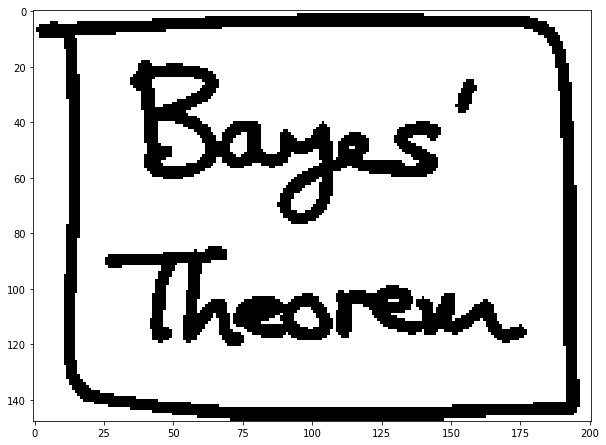

In [17]:
pylab.rcParams['figure.figsize'] = (10.0, 8.0)

# Read in the data:
im = plt.imread("Figure8_30a.png")[3:-3,3:-3,0].round() # Remove the border and keep a single binary channel
print("Image size: ",im.shape)
im = (-1 + 2*im)
print("Pixel values should be -1 or 1:", im.min(), im.max())

plt.imshow(im,cmap="bone")

def corrupt(im,pFlip = 50):  # Flip one in [pFlip] pixels 
    for r in range(im.shape[0]):
        for c in range(im.shape[1]):
            if np.random.randint(pFlip)==0:
                im[r,c] = -im[r,c]
                

## Markov Random Fields


In this part of the lab, we implement a Markov Random Field to denoise a binary image. We do this by iteratively minimizing the energy function defined below. 

Note that the image as it has been loaded above is in the form of a matrix, which allows us to keep track of neighbouring pixels.

So, first of all, we corrupt our image with 5% noise.

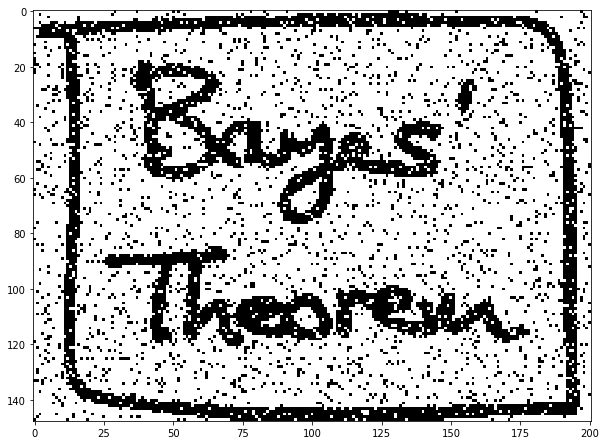

In [25]:
# This code is given


Y = im.copy()
corrupt(Y,10)
plt.imshow(Y,cmap="bone")
X = Y.copy()


## Defining the energy function

The energy function of the original image $\y$ and the reconstructed image $\x$ is given by

$$
E(\x,\y) = h\sum_i x_i -\beta \sum_{i,j\in \mathrm{ne}(i)} x_i x_j - \eta\sum_i x_iy_i
$$

where the sum over all pixels $i$ and neighobours $j$ of $i$. Notice that in this notation, the images are considered as vectors, while in the implementation we see them as matrices to make looking at neighbouring pixels easier.


-117212.0
-83890.0


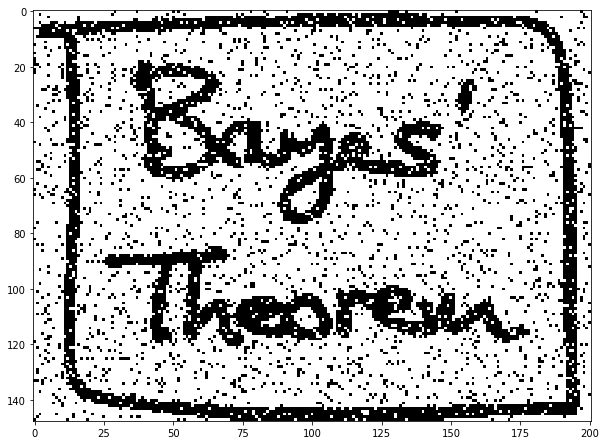

In [26]:
def energy (h,beta,eta,X,Y):
    O = Y[1:-1,1:-1]
    N = Y[0:-2,1:-1]
    S = Y[2:,1:-1]
    W = Y[1:-1,0:-2]
    E = Y[1:-1,2:]
    
    return h*sum(sum(Y)) - \
        beta*(sum(sum(O*N))+sum(sum(O*S))+sum(sum(O*E))+sum(sum(O*W))) - \
        eta*sum(sum(X*Y))

plt.imshow(X,cmap="bone")
print(energy(1,1,1,im,im))
print(energy(1,1,1,X,X))

In [27]:
# This code is given

def deltaE(h,beta,eta,X,Y,r,c):
    v = X[r,c]
    X[r,c]= 1-v
    E = energy(h,beta,eta,X,Y)
    X[r,c]= v
    return E - energy(h,beta,eta,X,Y)
    


**Question 2 [5 marks]** Can you figure out a more efficient way of implementing `deltaE`? What is the computational complexity of your solution?


**Answer** $O(1)$

In [28]:
# [ANSQ2] (do not delete this line)

# [/ANSQ2] (do not delete this line)

**Question 3 [5 marks]** Implement repeatedly iterating through all the pixels of the image, and flipping the pixels of the reconstruction $\y$ if that change results in a negative deltaE. 

0
1


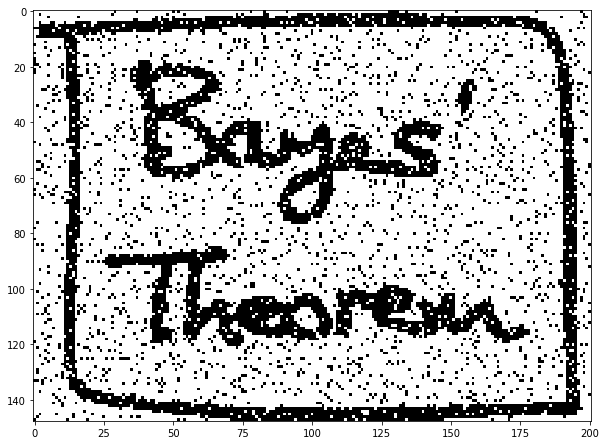

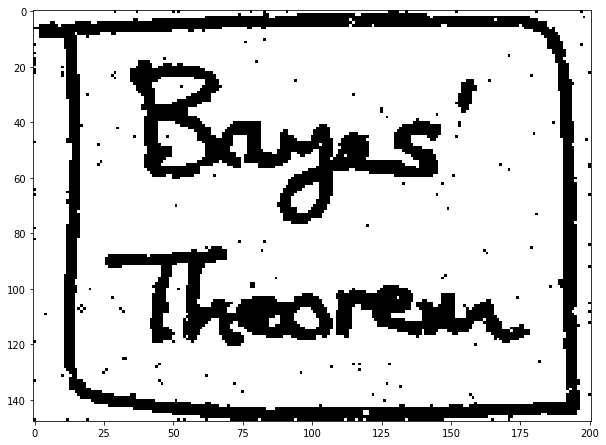

In [32]:
# [ANSQ3] (Do not delete this line)

# [/ANSQ3] (do not delete this line)